In [1]:
import matplotlib.pyplot as pt
import matplotlib.image
import numpy as np
import cv2

In [16]:

def show(*args, labels=[], show_axis=False, figsize=(10, 5), save_to: str = None):
    l = len(args)

    if len(labels) < l:
        labels += [None] * (l - len(labels))

    # fg, plots = pt.subplots(int(l ** .5), l // int(l ** .5), figsize=figsize)
    fg, plots = pt.subplots(1, l, figsize=figsize)

    try:
        plots = plots.flatten()
    except:
        plots = [plots]

    for m, p, l in zip(args, plots, labels):
        ax = p.imshow(m)

        if not show_axis:
            ax.axes.axis('off')

        if l:
            ax.axes.title.set_text(l)

    if save_to is not None:
        pt.savefig(save_to)


## Read Mask

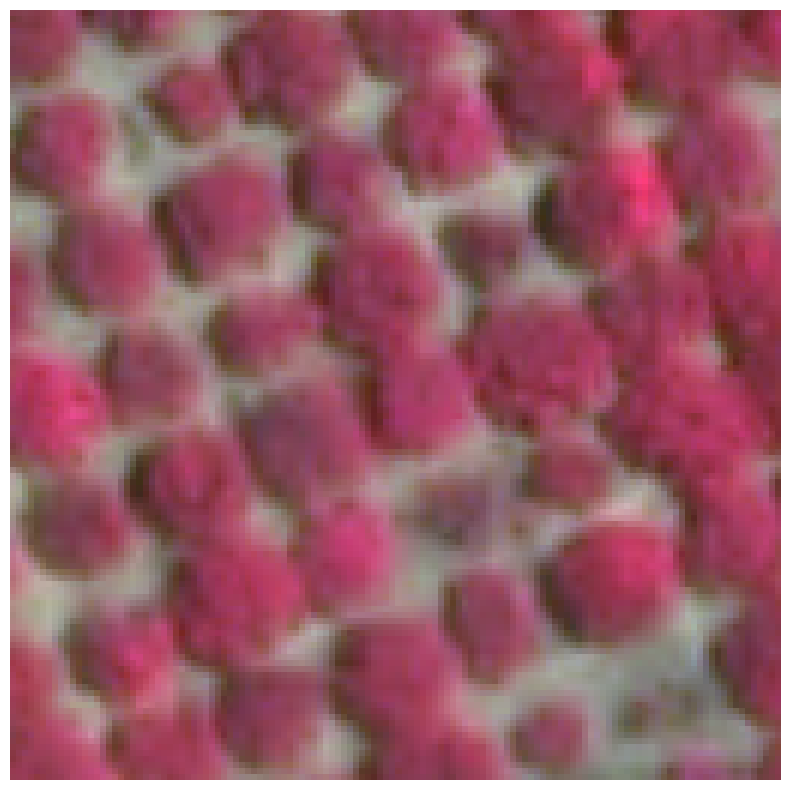

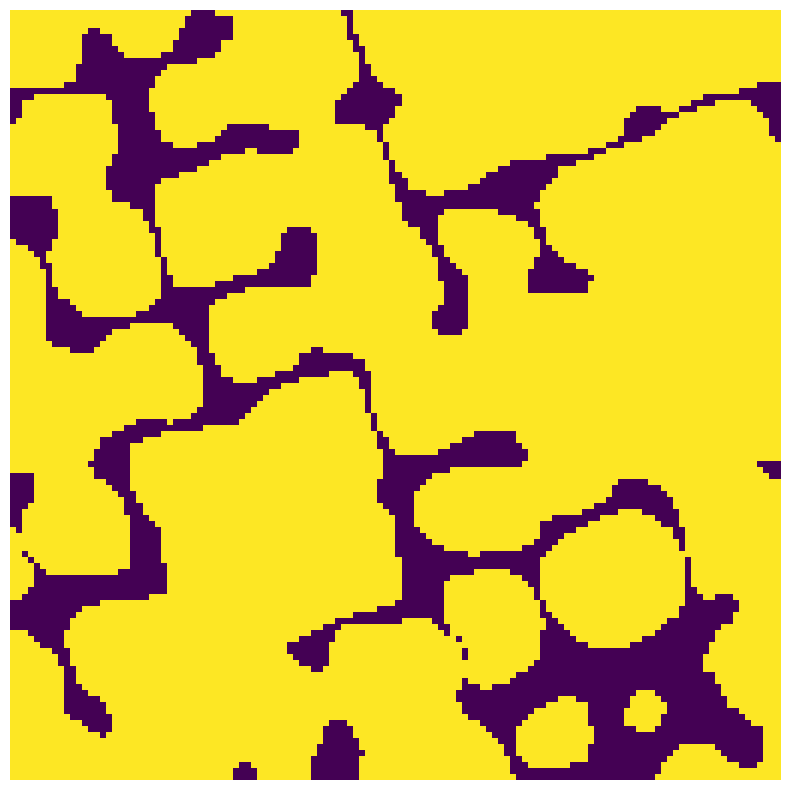

In [34]:
# READ MASK

KERN = np.ones((3, 3), dtype=np.uint8)

image_id = "high_density_mango_77"
# image_id = "high_density_coconut_9"
# image_id = "low_density_coconut_3"

s = cv2.imread(
    f"../data/satellite/images/{image_id}.tif",
    cv2.IMREAD_GRAYSCALE)

s_r = cv2.imread(
    f"../data/satellite/images/{image_id}.tif")
s_r = cv2.cvtColor(s_r, cv2.COLOR_BGR2RGB)

cv2.normalize(s, s, 0, 255, cv2.NORM_MINMAX)

k = cv2.imread(
    f"/Users/shreyas/Developer/Research/GroundingDINO/data/satellite/masks/{image_id}.png",
    cv2.IMREAD_GRAYSCALE)

_, s_t = cv2.threshold(s, 0, 512, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# mask = cv2.bitwise_and(s_t, k)
# mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, KERN, iterations=2)
mask = k

show(s_r, figsize=(20, 10))
show(mask, figsize=(20, 10))

In [20]:
smsk = mask.copy()
smsk[smsk != 0] = 255

np.unique(smsk)

array([  0, 255], dtype=uint8)

In [21]:
from cv2 import SimpleBlobDetector_create, SimpleBlobDetector_Params

params = SimpleBlobDetector_Params()
params.minArea = 0.2
params.minCircularity = .2
params.minDistBetweenBlobs = .1
params.minThreshold = 0
params.minConvexity = .2

detector = SimpleBlobDetector_create(params)

detector.empty()
keypoints = detector.detect(smsk)

print(f"{len(keypoints)} keypoints")

0 keypoints


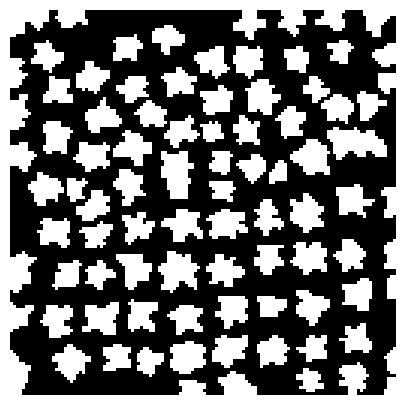

In [23]:
rmsk = smsk.copy()[..., None].repeat(3, axis=-1)

cv2.drawKeypoints(rmsk, keypoints, rmsk, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show(rmsk)

In [24]:
for k in dir(params):
    if k.startswith("__"):
        continue

    print("{:>28}\t{}".format(k, getattr(params, k)))

                   blobColor	0
             collectContours	False
                filterByArea	True
         filterByCircularity	False
               filterByColor	True
           filterByConvexity	True
             filterByInertia	True
                     maxArea	5000.0
              maxCircularity	3.4028234663852886e+38
                maxConvexity	3.4028234663852886e+38
             maxInertiaRatio	3.4028234663852886e+38
                maxThreshold	220.0
                     minArea	0.20000000298023224
              minCircularity	0.20000000298023224
                minConvexity	0.20000000298023224
         minDistBetweenBlobs	0.10000000149011612
             minInertiaRatio	0.10000000149011612
            minRepeatability	2
                minThreshold	0.0
               thresholdStep	10.0


## Markers

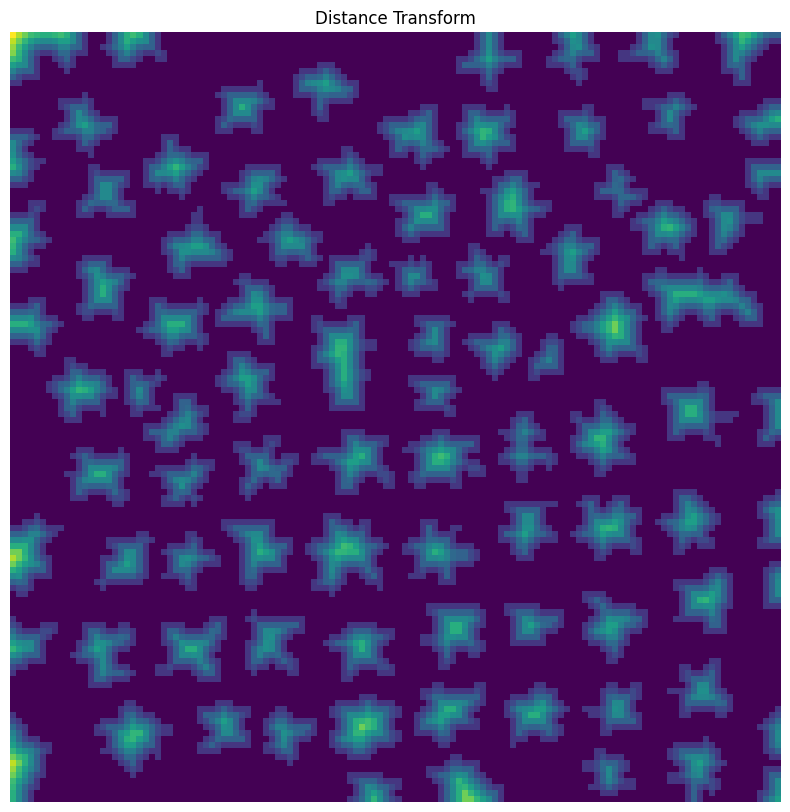

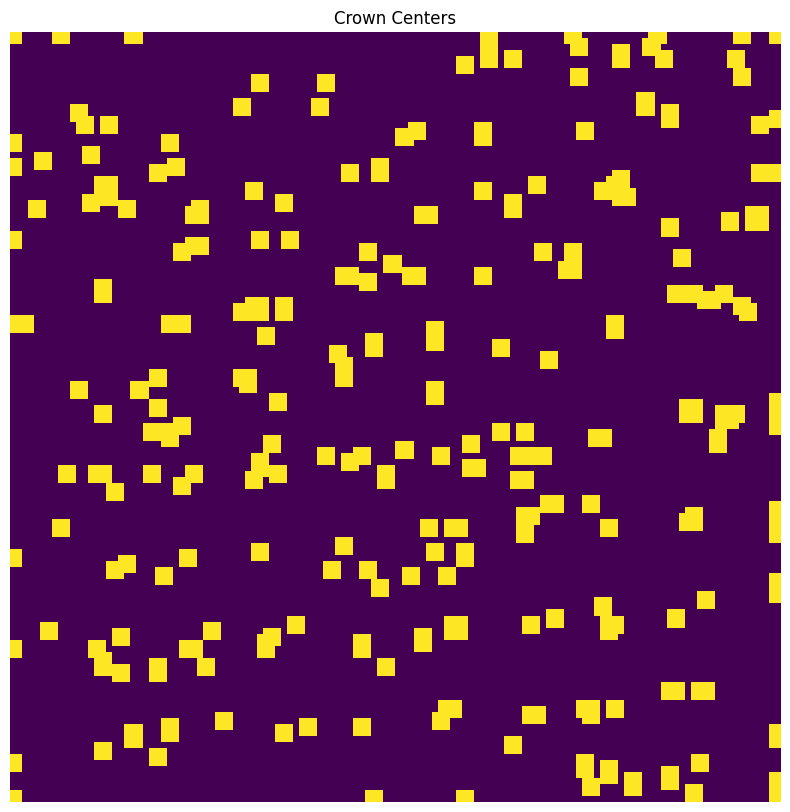

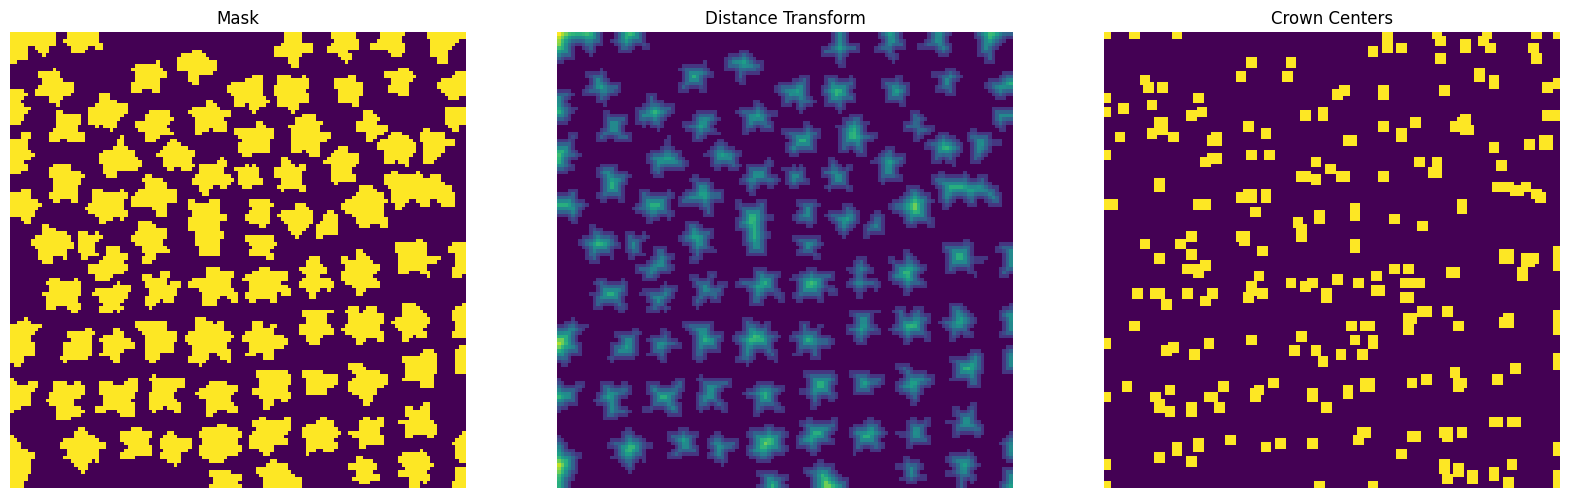

In [27]:
# MARKERS

def around(d, i, j):
    rs = d[
        max(i-1, 0):min(i+2, d.shape[0]),
        max(j-1, 0):min(j+2, d.shape[1])]

    return rs

d = cv2.distanceTransform(mask, cv2.DIST_L2, 5)

peaks = np.zeros_like(d, dtype=np.uint8)

for i in range(d.shape[0]):
    for j in range(d.shape[1]):
        if d[i, j] == 0:
            continue

        z = around(d, i, j)

        if d[i, j] == z.max():
            peaks[i, j] = 1

peaks = cv2.dilate(peaks, KERN, iterations=1)
peaks[peaks != 0] = 255

# d = peaks

show(d, labels=["Distance Transform", "Crown Centers"], show_axis=False, figsize=(20, 10))
show(peaks, labels=["Crown Centers"], show_axis=False, figsize=(20, 10))
show(mask, d, peaks, labels=["Mask", "Distance Transform", "Crown Centers"], show_axis=False, figsize=(20, 10))

## Prepare

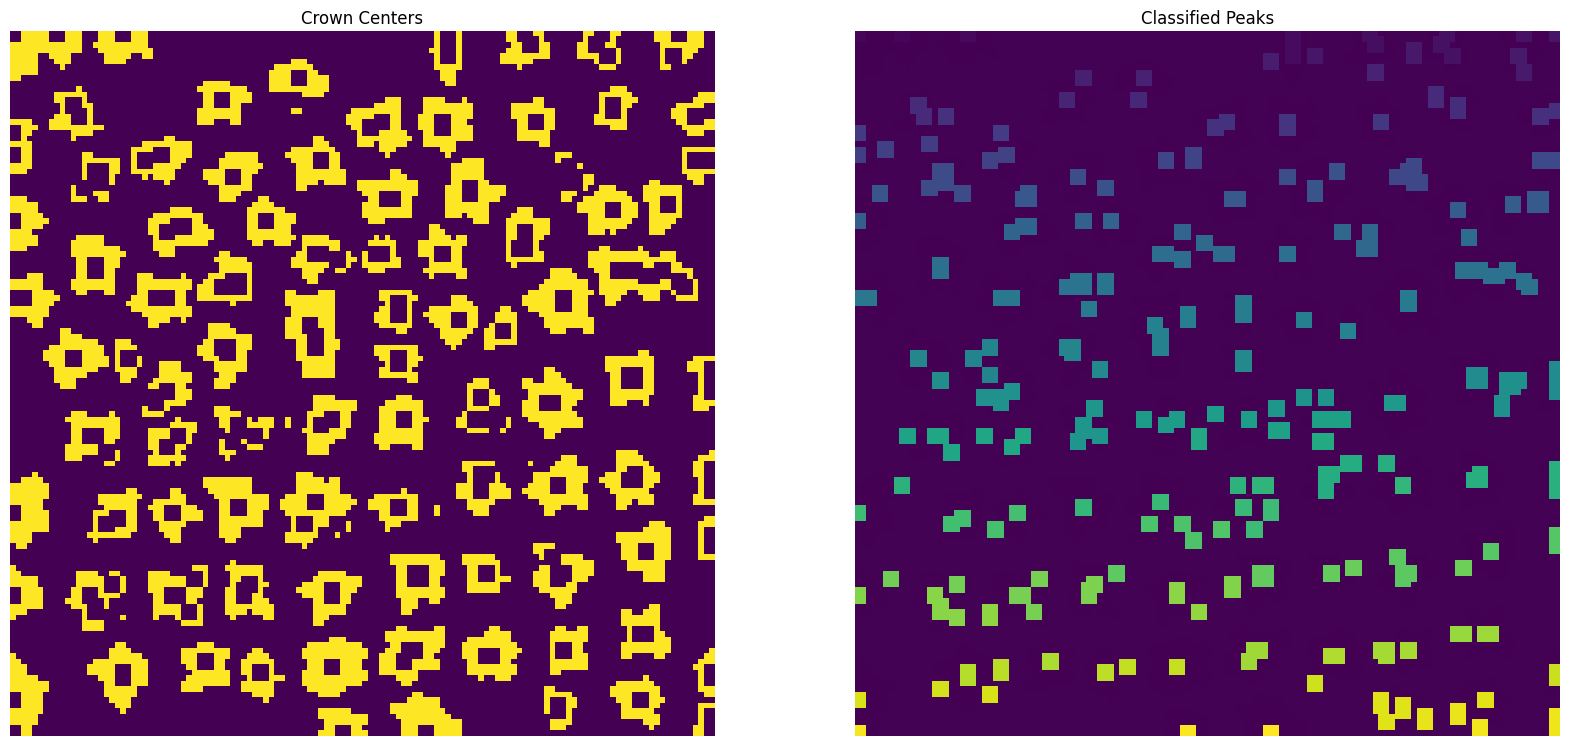

In [29]:
# PREPARE
_, markers = cv2.connectedComponents(peaks)
markers += 1

unknown = cv2.subtract(mask, peaks)
markers[unknown != 0] = 0

show(unknown, markers, labels=["Crown Centers", "Classified Peaks"], figsize=(20, 10))

## Watershed Algorithm

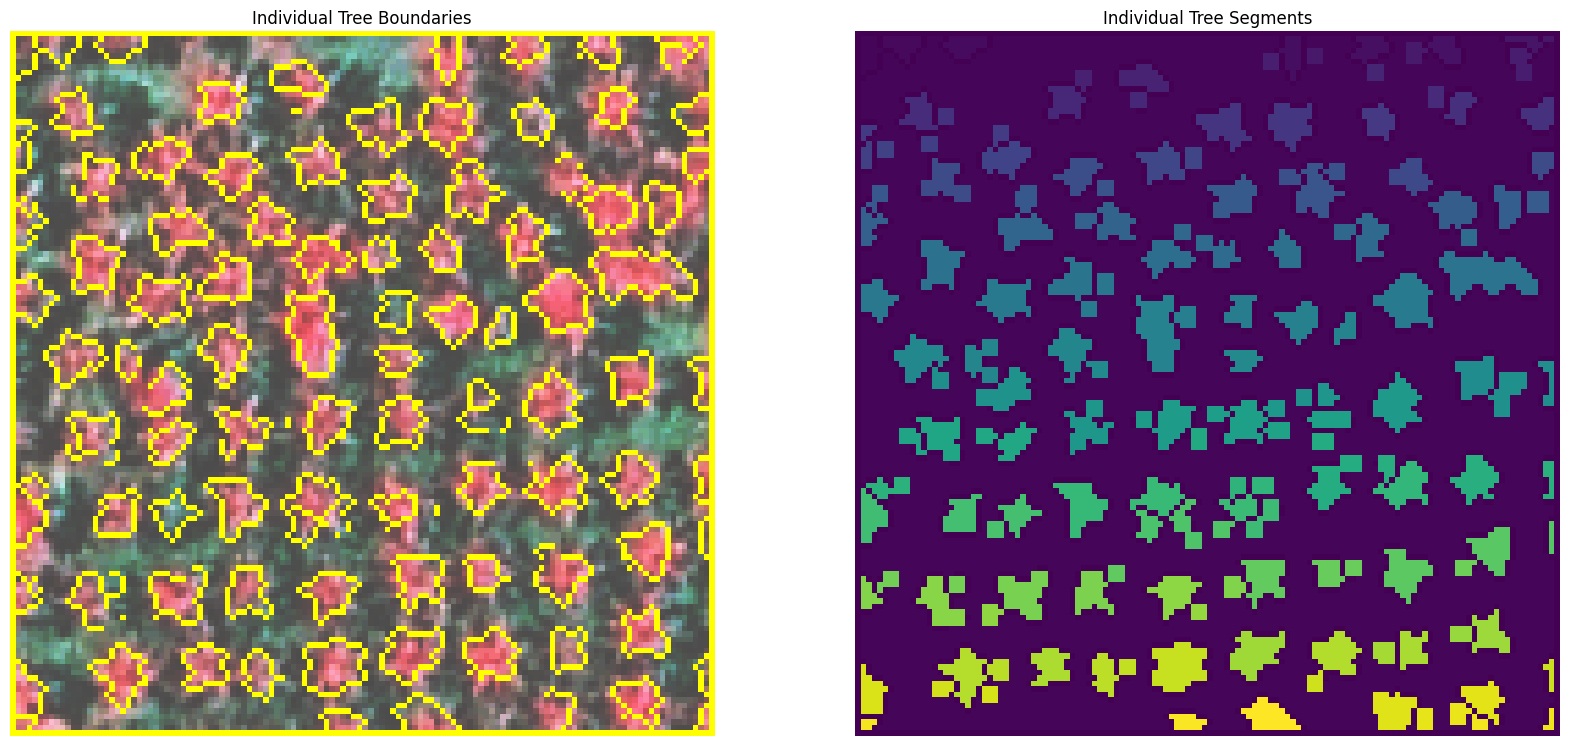

In [31]:
# WATERSHED

watershed = cv2.watershed(cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR), markers)

s = cv2.imread(
    f"../data/satellite/images/{image_id}.tif")
s = cv2.cvtColor(s, cv2.COLOR_BGR2RGB)

s[watershed == -1] = [255, 255, 0]

show(s, watershed, labels=["Individual Tree Boundaries", "Individual Tree Segments"], show_axis=False, figsize=(20, 10))

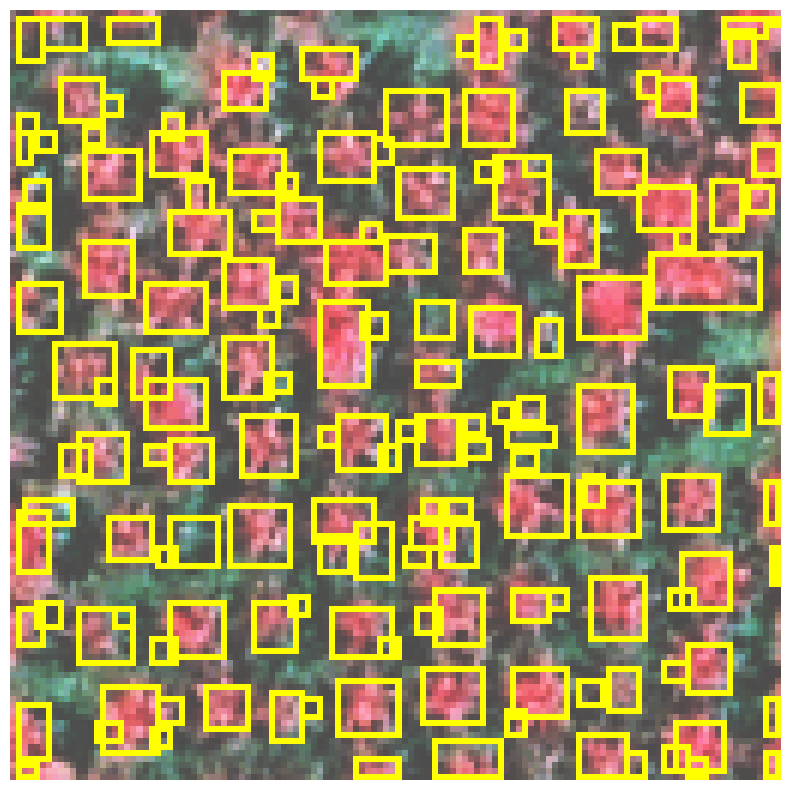

In [33]:
def rects(s):
    r = []

    for v in np.unique(s):
        if v <= 1:
            continue

        ct = cv2.findContours(
            (s == v).astype(np.uint8),
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)

        x, y, w, h = cv2.boundingRect(ct[0][0])
        r.append((x, y, w, h))

        # cv2.rectangle(r, (x, y), (x + w, y + h), 255)
    return r

simg = cv2.imread(
    f"../data/satellite/images/{image_id}.tif")
simg = cv2.cvtColor(simg, cv2.COLOR_BGR2RGB)

rects_ = rects(watershed)
for r in rects_:
    cv2.rectangle(simg, (r[0], r[1]), (r[0] + r[2], r[1] + r[3]), (255, 255, 0))

show(simg, show_axis=False, figsize=(20, 10))

## Dataset Rewrite

In [ ]:
KERN = np.ones((3, 3), dtype=np.uint8)

def rects(s):
    r = []

    for v in np.unique(s):
        if v <= 1:
            continue

        ct = cv2.findContours(
            (s == v).astype(np.uint8),
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)

        x, y, w, h = cv2.boundingRect(ct[0][0])
        r.append((x, y, w, h))

        # cv2.rectangle(r, (x, y), (x + w, y + h), 255)
    return r

def tree_split(s, k):
    # READ MASK

    cv2.normalize(s, s, 0, 255, cv2.NORM_MINMAX)
    _, s_t = cv2.threshold(s, 0, 512, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # mask = cv2.bitwise_and(s_t, k)
    # mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, KERN, iterations=2)
    mask = k

    # MARKERS

    d = cv2.distanceTransform(mask, cv2.DIST_L2, 5)

    peaks = np.zeros_like(d, dtype=np.uint8)

    for i in range(d.shape[0]):
        for j in range(d.shape[1]):
            if d[i, j] == 0:
                continue

            z = around(d, i, j)

            if d[i, j] == z.max():
                peaks[i, j] = 1

    peaks = cv2.dilate(peaks, KERN, iterations=1)
    peaks[peaks != 0] = 255

    d = peaks

    # d = cv2.normalize(d, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # d = cv2.adaptiveThreshold(d, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, -1)
    # # d = cv2.morphologyEx(d, cv2.MORPH_OPEN, KERN, iterations=1)

    # PREPARE
    _, markers = cv2.connectedComponents(d)
    markers += 1

    unknown = cv2.subtract(mask, d)
    markers[unknown != 0] = 0

    # WATERSHED
    rs = cv2.watershed(cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR), markers)
    return rs, rects(rs)


In [21]:
from tqdm import tqdm
from torch.utils.data import random_split
import os

root = "..//DINOv2/data/satellite"

images = os.path.join(root, "images")
masks = os.path.join(root, "masks")

coco = {
    "images": [],
    "annotations": [],
    "categories": [
        { "id": 1, "name": "coconut" },
        { "id": 2, "name": "mango" },
    ]
}

coco_train = {
    "images": [],
    "annotations": [],
    "categories": [
        { "id": 1, "name": "coconut" },
        { "id": 2, "name": "mango" },
    ]
}

coco_test = {
    "images": [],
    "annotations": [],
    "categories": [
        { "id": 1, "name": "coconut" },
        { "id": 2, "name": "mango" },
    ]
}

images_id = 0
annotations_id = 0

image_list = []

for simg in tqdm(os.listdir(images)):
    if not simg.lower().endswith(".tif"):
        continue

    image_id, _ = os.path.splitext(simg)
    mimg = f"{image_id}.png"

    k = cv2.imread(os.path.join(masks, mimg), cv2.IMREAD_GRAYSCALE)

    if np.any(k):
        image_list.append(simg)

train_list, test_list = random_split(image_list, [.8, .2])
print(len(train_list), len(test_list))

for simg in tqdm(image_list):
    if not simg.lower().endswith(".tif"):
        continue

    image_id, _ = os.path.splitext(simg)

    mimg = f"{image_id}.png"

    s = cv2.imread(os.path.join(images, simg), cv2.IMREAD_GRAYSCALE)
    k = cv2.imread(os.path.join(masks, mimg), cv2.IMREAD_GRAYSCALE)

    if not np.any(k):
        continue

    rs, rects_ = tree_split(s.copy(), k.copy())
    s[rs == -1] = 255

    category, *_ = np.unique(k[k != 0])

    images_id += 1

    coco["images"].append({
        "file_name": simg,
        "width": s.shape[1],
        "height": s.shape[0],
        "id": images_id
    })

    r_ = rs.copy()
    for x, y, w, h in rects_:
        annotations_id += 1

        coco["annotations"].append({
            "id": annotations_id,
            "image_id": images_id,
            "category_id": category.item(),
            "bbox": [x, y, w, h],
            "segmentation": [
                x, y,
                x, y + h,
                x + w, y + h,
                x + w, y,
            ],
            "area": float(w * h),
            "iscrowd": 0
        })

        cv2.rectangle(r_, (x, y), (x + w, y + h), 255)

images_id = 0
annotations_id = 0

for simg in tqdm(train_list):
    if not simg.lower().endswith(".tif"):
        continue

    image_id, _ = os.path.splitext(simg)

    mimg = f"{image_id}.png"

    s = cv2.imread(os.path.join(images, simg), cv2.IMREAD_GRAYSCALE)
    k = cv2.imread(os.path.join(masks, mimg), cv2.IMREAD_GRAYSCALE)

    if not np.any(k):
        continue

    rs, rects_ = tree_split(s.copy(), k.copy())
    s[rs == -1] = 255

    category, *_ = np.unique(k[k != 0])

    images_id += 1

    coco_train["images"].append({
        "file_name": simg,
        "width": s.shape[1],
        "height": s.shape[0],
        "id": images_id
    })

    r_ = rs.copy()
    for x, y, w, h in rects_:
        annotations_id += 1

        coco_train["annotations"].append({
            "id": annotations_id,
            "image_id": images_id,
            "category_id": category.item(),
            "bbox": [x, y, w, h],
            "segmentation": [
                x, y,
                x, y + h,
                x + w, y + h,
                x + w, y,
            ],
            "area": float(w * h),
            "iscrowd": 0
        })

        cv2.rectangle(r_, (x, y), (x + w, y + h), 255)


images_id = 0
annotations_id = 0

for simg in tqdm(test_list):
    if not simg.lower().endswith(".tif"):
        continue

    image_id, _ = os.path.splitext(simg)

    mimg = f"{image_id}.png"

    s = cv2.imread(os.path.join(images, simg), cv2.IMREAD_GRAYSCALE)
    k = cv2.imread(os.path.join(masks, mimg), cv2.IMREAD_GRAYSCALE)

    if not np.any(k):
        continue

    rs, rects_ = tree_split(s.copy(), k.copy())
    s[rs == -1] = 255

    category, *_ = np.unique(k[k != 0])

    images_id += 1

    coco_test["images"].append({
        "file_name": simg,
        "width": s.shape[1],
        "height": s.shape[0],
        "id": images_id
    })

    r_ = rs.copy()
    for x, y, w, h in rects_:
        annotations_id += 1

        coco_test["annotations"].append({
            "id": annotations_id,
            "image_id": images_id,
            "category_id": category.item(),
            "bbox": [x, y, w, h],
            "segmentation": [
                x, y,
                x, y + h,
                x + w, y + h,
                x + w, y,
            ],
            "area": float(w * h),
            "iscrowd": 0
        })

        cv2.rectangle(r_, (x, y), (x + w, y + h), 255)


FileNotFoundError: [Errno 2] No such file or directory: '..//DINOv2/data/satellite/images'

In [13]:
len(coco["images"])

535

In [42]:
print("COCO", len(coco["images"]), len(coco["annotations"]), sep='\t')
print("train", len(coco_train["images"]), len(coco_train["annotations"]), sep='\t')
print("test", len(coco_test["images"]), len(coco_test["annotations"]), sep='\t')

COCO	535	29478
train	428	23605
test	107	5873


In [14]:
import json

json.dump(
    coco,
    open("/Users/shreyas/Developer/DINOv2/notebooks/annotations.json", 'w'),
    indent=2)

# json.dump(
#     coco_train,
#     open("/Users/shreyas/Developer/DINOv2/notebooks/train.json", 'w'),
#     indent=2)

# json.dump(
#     coco_test,
#     open("/Users/shreyas/Developer/DINOv2/notebooks/test.json", 'w'),
#     indent=2)

In [31]:
coco_ = json.load(open("/Users/shreyas/Developer/DINOv2/data/satellite/annotations.json"))
print(len(coco_["images"]), len(coco_["annotations"]))

256 7115
